In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import ElasticNet


pd.set_option("display.max_columns", 200)


In [2]:
# -------------------
# Configuration
# -------------------
DATA_PATH = "/Users/koniks/Desktop/Github Folder/public-program-evaluation/data/clean/analysis_dataset_ward_level.csv"
TARGET_COL = "BusServiceIntensity"
TEST_SIZE = 0.20
RANDOM_STATE = 42

In [3]:
# -------------------
# Load data
# -------------------
df = pd.read_csv(DATA_PATH)
print("Rows, cols:", df.shape)
display(df.head())

print("\nMissingness (selected):")
display(df[[TARGET_COL, "population_density", "district", "ward_area_km2", "Stops_i", "Routes_i"]].isna().mean().to_frame("missing_rate").T)


Rows, cols: (322, 35)


,ward_key,ward_id,ward_name,district,ward_area_km2,Stops_i,Routes_i,TripsPerDay_i,zStops,zRoutes,zTripsPerDay,BusServiceIntensity,Population,population_density,vehicle_ownership,dist_to_rto_m,nearest_rto,nighttime_lights,ntl_median,ntl_total,ntl_max,ntl_lit_pixels,metro_access_km,road_density_km_per_km2,district_Central,district_East,district_New Delhi,district_North,district_North East,district_North West,district_Shahdara,district_South,district_South East,district_South West,district_West
0,CANT_1,CANT_1,DELHI CANTT CHARGE 1,New Delhi,1.274680,5.0,15.0,390.0,-0.680046,-0.740670,-0.802882,-0.741199,NaN,NaN,29352,3233.226766,RAJA GARDEN,34.159935,34.122707,170.799683,45.387379,5,0.596749,12.596817,False,False,True,False,False,False,False,False,False,False,False
1,CANT_2,CANT_2,DELHI CANTT CHARGE 2,New Delhi,8.760167,20.0,111.0,3634.0,0.182985,-0.029236,-0.100547,0.017734,NaN,NaN,29352,4661.855167,RAJA GARDEN,25.190216,24.113720,1209.130371,42.099144,48,0.305693,5.908254,False,False,True,False,False,False,False,False,False,False,False
2,CANT_4,CANT_4,DELHI CANTT CHARGE 4,South,8.382204,14.0,160.0,4878.0,-0.162227,0.333891,0.168783,0.113482,NaN,NaN,33224,5551.821985,VASANT VIHAR,31.163273,31.783758,1308.857422,62.445789,42,0.000000,10.569377,False,False,False,False,False,False,False,True,False,False,False
3,CANT_5,CANT_5,DELHI CANTT CHARGE 5,New Delhi,3.493526,9.0,77.0,2951.0,-0.449904,-0.281202,-0.248418,-0.326508,NaN,NaN,31757,7113.443040,JANAKPURI,37.191505,36.729408,706.638611,50.338192,19,1.019909,10.074568,False,False,True,False,False,False,False,False,False,False,False
4,CANT_6,CANT_6,DELHI CANTT CHARGE 6,New Delhi,15.247664,32.0,210.0,6392.0,0.873410,0.704430,0.496569,0.691470,NaN,NaN,31757,6295.381595,JANAKPURI,43.255730,40.173660,3546.969971,138.778931,82,0.000000,10.934307,False,False,True,False,False,False,False,False,False,False,False



Missingness (selected):


,BusServiceIntensity,population_density,district,ward_area_km2,Stops_i,Routes_i
missing_rate,0.127329,0.23913,0.0,0.0,0.127329,0.127329


In [4]:
# -------------------
# Feature engineering
# -------------------

# 1) Derived infrastructure densities
# Guard against zero area
df["ward_area_km2"] = df["ward_area_km2"].replace({0: np.nan})
df["stops_per_km2"] = df["Stops_i"] / df["ward_area_km2"]
df["routes_per_km2"] = df["Routes_i"] / df["ward_area_km2"]

# 2) Handle missing population_density: missing indicator + district-median imputation then global median
df["population_density__missing"] = df["population_density"].isna().astype(int)

# district median (only where district is known)
district_median = df.groupby("district")["population_density"].transform("median")
df["population_density"] = df["population_density"].fillna(district_median)

# global median fallback
df["population_density"] = df["population_density"].fillna(df["population_density"].median())

# 3) Drop rows missing the target
before = len(df)
df = df.dropna(subset=[TARGET_COL]).copy()
print(f"Dropped {before - len(df)} rows with missing target ({TARGET_COL}). Remaining:", len(df))

# 4) Target transform
df["y"] = np.log1p(df[TARGET_COL])

# 5) Choose predictors
base_numeric_features = [
    "stops_per_km2",
    "routes_per_km2",
    "population_density",
    "vehicle_ownership",
    "dist_to_rto_m",
    "nighttime_lights",
    "metro_access_km",
    "road_density_km_per_km2",
    "population_density__missing"
]

# Sanity check
base_numeric_features = [c for c in base_numeric_features if c in df.columns]

# 6) District fixed effects
district_dummies = pd.get_dummies(df["district"], prefix="district", drop_first=True)
X = pd.concat([df[base_numeric_features], district_dummies], axis=1)

feature_names = X.columns.tolist()
print("Number of features:", len(feature_names))
display(X.head())


Dropped 41 rows with missing target (BusServiceIntensity). Remaining: 281
Number of features: 19


,stops_per_km2,routes_per_km2,population_density,vehicle_ownership,dist_to_rto_m,nighttime_lights,metro_access_km,road_density_km_per_km2,population_density__missing,district_East,district_New Delhi,district_North,district_North East,district_North West,district_Shahdara,district_South,district_South East,district_South West,district_West
0,3.922552,11.767656,24815.585341,29352,3233.226766,34.159935,0.596749,12.596817,1,False,True,False,False,False,False,False,False,False,False
1,2.283061,12.670991,24815.585341,29352,4661.855167,25.190216,0.305693,5.908254,1,False,True,False,False,False,False,False,False,False,False
2,1.670205,19.088058,19842.723743,33224,5551.821985,31.163273,0.000000,10.569377,1,False,False,False,False,False,False,True,False,False,False
3,2.576194,22.040771,24815.585341,31757,7113.443040,37.191505,1.019909,10.074568,1,False,True,False,False,False,False,False,False,False,False
4,2.098682,13.772601,24815.585341,31757,6295.381595,43.255730,0.000000,10.934307,1,False,True,False,False,False,False,False,False,False,False


In [5]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.values)
X_scaled = pd.DataFrame(X_scaled, columns=feature_names, index=df.index)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, df["y"], test_size=TEST_SIZE, random_state=RANDOM_STATE
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

# -------------------
# CV fit: search alpha x l1_ratio, pick lowest CV MSE
# -------------------
L1_RATIOS = [.1, .3, .5, .7, .9, .95, .99, 1.0]

cv_model = ElasticNetCV(
    l1_ratio=L1_RATIOS,
    n_alphas=200,
    cv=10,
    random_state=RANDOM_STATE,
    max_iter=200000
)
cv_model.fit(X_train.values, y_train.values)

best_alpha = cv_model.alpha_
best_l1 = cv_model.l1_ratio_
print("Chosen (CV) alpha:", best_alpha)
print("Chosen (CV) l1_ratio:", best_l1)


Train shape: (224, 19) Test shape: (57, 19)


/Users/koniks/miniconda3/envs/DAP/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(


Chosen (CV) alpha: 0.06642524144738647
Chosen (CV) l1_ratio: 0.1


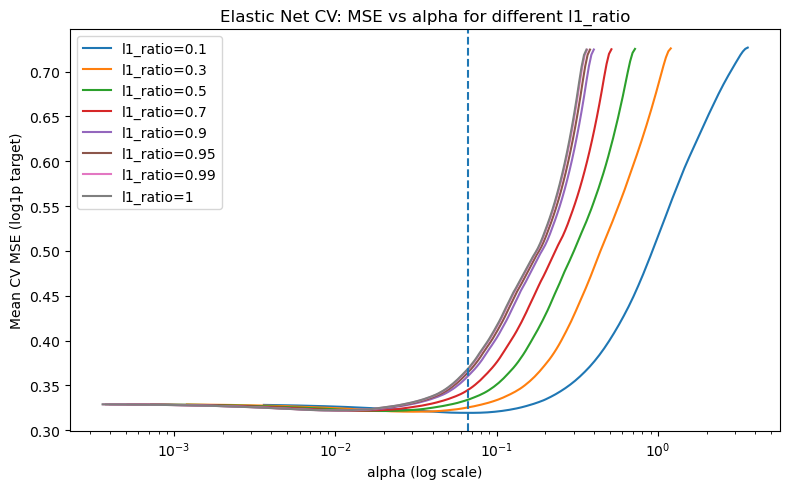

In [6]:
# -------------------
# Visual: CV MSE vs alpha across l1_ratio values
# -------------------
mse_path = cv_model.mse_path_          # (n_l1, n_alpha, n_folds)
mean_mse = mse_path.mean(axis=2)       # (n_l1, n_alpha)

alphas = cv_model.alphas_              # (n_l1, n_alpha) when multiple l1_ratio
l1s = np.array(L1_RATIOS, dtype=float)

plt.figure(figsize=(8, 5))

# If alphas is 2D (multiple l1_ratio), plot row-by-row
if alphas.ndim == 2:
    for i, l1 in enumerate(l1s):
        plt.plot(alphas[i], mean_mse[i], label=f"l1_ratio={l1:g}")
else:
    # Single l1_ratio case
    plt.plot(alphas, mean_mse, label=f"l1_ratio={float(l1s[0]):g}")

plt.axvline(cv_model.alpha_, linestyle="--")
plt.xscale("log")
plt.xlabel("alpha (log scale)")
plt.ylabel("Mean CV MSE (log1p target)")
plt.title("Elastic Net CV: MSE vs alpha for different l1_ratio")
plt.legend()
plt.tight_layout()
plt.show()

In [7]:
# -------------------
# Final refit: fixed ElasticNet using the CV-chosen alpha (and l1_ratio)
# -------------------
final_model = ElasticNet(
    alpha=best_alpha,
    l1_ratio=best_l1,
    max_iter=200000,
    random_state=RANDOM_STATE
)
final_model.fit(X_train.values, y_train.values)

,alpha,np.float64(0....2524144738647)
,l1_ratio,np.float64(0.1)
,fit_intercept,True
,precompute,False
,max_iter,200000
,copy_X,True
,tol,0.0001
,warm_start,False
,positive,False
,random_state,42
,selection,'cyclic'


Performance in log space (predicting log1p(target))
  RMSE: 0.4600960708362841
  MAE : 0.3528750102074857
  R^2 : 0.6491268179336939

Performance in original target units (unclipped)
  RMSE: 0.6238329735812608
  MAE : 0.35173545419363206
  R^2 : 0.4935996969774916


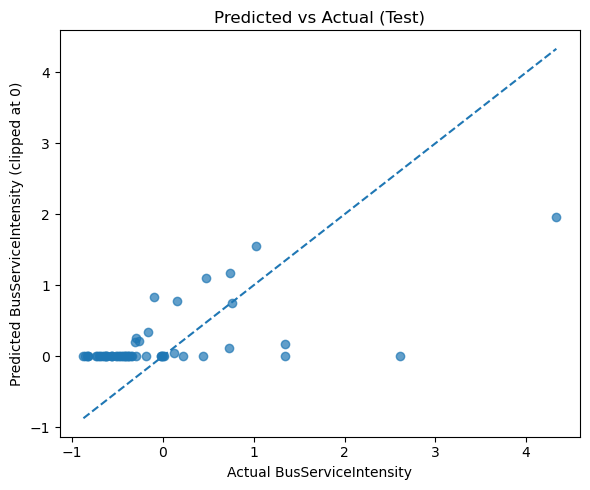

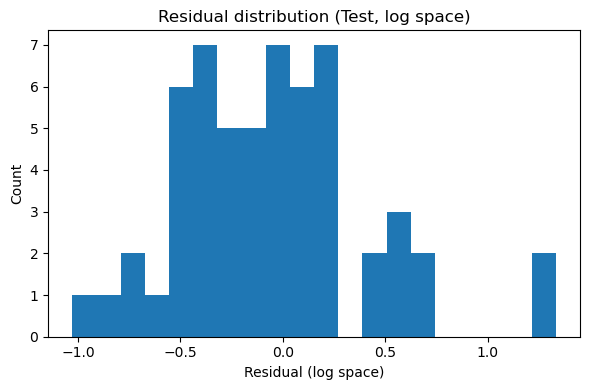

In [8]:
# -------------------
# Test-set evaluation (use final_model, NOT cv_model)
# -------------------
y_pred_test = final_model.predict(X_test.values)

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

print("Performance in log space (predicting log1p(target))")
print("  RMSE:", rmse(y_test, y_pred_test))
print("  MAE :", mean_absolute_error(y_test, y_pred_test))
print("  R^2 :", r2_score(y_test, y_pred_test))

# Convert back to original target units
y_test_orig = np.expm1(y_test)
y_pred_orig = np.expm1(y_pred_test)

print("\nPerformance in original target units (unclipped)")
print("  RMSE:", rmse(y_test_orig, y_pred_orig))
print("  MAE :", mean_absolute_error(y_test_orig, y_pred_orig))
print("  R^2 :", r2_score(y_test_orig, y_pred_orig))

# For visualization, clip negative predictions at 0
y_pred_orig_clip = np.maximum(0, y_pred_orig)

# Visual: predicted vs actual (original units)
plt.figure(figsize=(6, 5))
plt.scatter(y_test_orig, y_pred_orig_clip, alpha=0.7)
mn = float(min(y_test_orig.min(), y_pred_orig_clip.min()))
mx = float(max(y_test_orig.max(), y_pred_orig_clip.max()))
plt.plot([mn, mx], [mn, mx], linestyle="--")
plt.xlabel("Actual BusServiceIntensity")
plt.ylabel("Predicted BusServiceIntensity (clipped at 0)")
plt.title("Predicted vs Actual (Test)")
plt.tight_layout()
plt.show()

# Residuals in log space
resid = y_test - y_pred_test
plt.figure(figsize=(6, 4))
plt.hist(resid, bins=20)
plt.xlabel("Residual (log space)")
plt.ylabel("Count")
plt.title("Residual distribution (Test, log space)")
plt.tight_layout()
plt.show()


#### Research Question 1 (RQ1): What predictors best explain bus service intensity (controlling for district fixed effects)?

,coef,abs_coef
population_density,-0.369873,0.369873
stops_per_km2,0.286525,0.286525
routes_per_km2,0.209404,0.209404
district_South West,0.180941,0.180941
nighttime_lights,-0.138383,0.138383
dist_to_rto_m,0.129097,0.129097
district_North West,0.112670,0.112670
district_North East,-0.094820,0.094820
district_West,0.084303,0.084303
district_Shahdara,-0.068356,0.068356


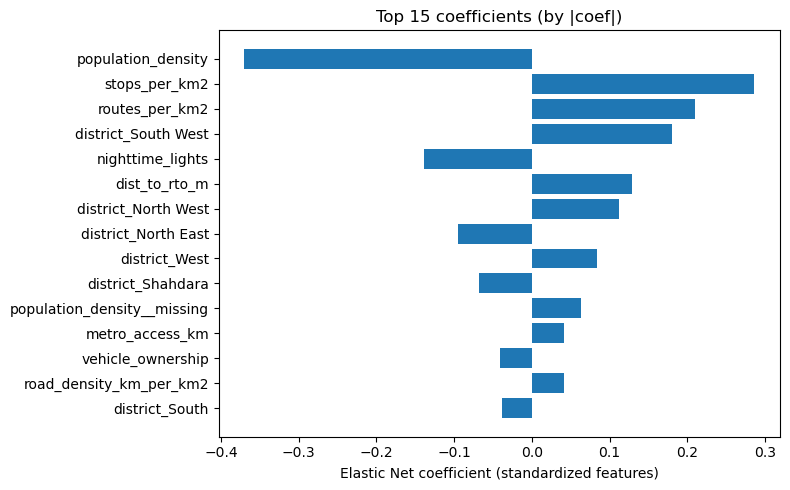

In [10]:
# -------------------
# RQ1: Coefficient interpretation
# -------------------
coefs = pd.Series(final_model.coef_, index=feature_names).sort_values()
coef_df = coefs.to_frame("coef").assign(abs_coef=lambda d: d["coef"].abs()).sort_values("abs_coef", ascending=False)

display(coef_df.head(20))

# Bar plot of top coefficients by absolute value
TOP_N = 15
top = coef_df.head(TOP_N).iloc[::-1]  # reverse for nicer plotting

plt.figure(figsize=(8, 5))
plt.barh(top.index, top["coef"])
plt.xlabel("Elastic Net coefficient (standardized features)")
plt.title(f"Top {TOP_N} coefficients (by |coef|)")
plt.tight_layout()
plt.show()


#### Research Question 2 (RQ2): Where would adding stops/routes yield the highest predicted gain per cost?

Scenario targets (densities):
  stops_per_km2 : 7.4741865958170335
  routes_per_km2: 48.835198670446324


,ward_name,district,pred_baseline,pred_scenario,pred_gain,pct_gain_index,delta_stops,delta_routes,investment_cost_inr,investment_cost_lakh,roi_gain_per_1_lakh,lakh_per_0_01_gain
41,CHAUHAN BANGER,Shahdara,-0.848136,-0.574056,0.274080,32.315582,2.0,0.0,900000.0,9.0,0.030453,0.328371
150,NEW RANJIT NAGAR,West,-0.547410,-0.258088,0.289322,52.852914,3.0,0.0,1350000.0,13.5,0.021431,0.466608
272,MOTI NAGAR,West,-0.315560,-0.232186,0.083374,26.421065,1.0,0.0,450000.0,4.5,0.018528,0.539735
36,SUNDER NAGARI,Shahdara,-1.021970,-0.945573,0.076397,7.475490,1.0,0.0,450000.0,4.5,0.016977,0.589026
159,DEPUTY GANJ,Central,-0.336501,-0.186459,0.150042,44.588894,2.0,0.0,900000.0,9.0,0.016671,0.599832
222,SHAKARPUR,East,-1.066983,-0.857317,0.209665,19.650314,3.0,0.0,1350000.0,13.5,0.015531,0.643883
144,RAGHUBAR PURA,Shahdara,-0.557976,-0.496117,0.061859,11.086246,1.0,0.0,450000.0,4.5,0.013746,0.727466
253,ADARASH NAGAR,North,-0.774035,-0.534035,0.240000,31.006309,4.0,0.0,1800000.0,18.0,0.013333,0.750001
237,RANA PRATAP BAGH,Central,-0.493465,-0.317408,0.176057,35.677656,3.0,0.0,1350000.0,13.5,0.013041,0.766798
163,TILAK NAGAR,West,-0.151414,0.006325,0.157739,104.177240,3.0,0.0,1350000.0,13.5,0.011684,0.855844


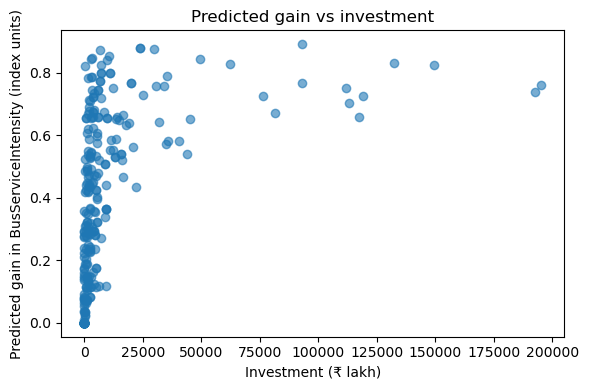

In [11]:
# -------------------
# RQ2: Simple ROI scenario analysis (India INR-based costs)
# Scenario: raise stop/route *densities* to the 75th percentile where below that threshold.
# Implementation detail: because densities are derived from (Stops_i, Routes_i, ward_area_km2),
# we increase Stops_i / Routes_i to meet the density targets.
#
# Interpretability fix:
# BusServiceIntensity is an average of three z-scores:
#   (zStops + zRoutes + zTripsPerDay) / 3
# so predictions are in "index units" (≈ SDs of the composite), NOT trips/day.
# We therefore report ROI as:
#   - index gain per ₹1 lakh, and
#   - ₹ lakh per +0.01 index gain
# -------------------

df_roi = df.copy()

# Baseline densities
baseline_stops_density  = df_roi["stops_per_km2"]
baseline_routes_density = df_roi["routes_per_km2"]

TARGET_PERCENTILE = 0.75
target_stops_density  = baseline_stops_density.quantile(TARGET_PERCENTILE)
target_routes_density = baseline_routes_density.quantile(TARGET_PERCENTILE)

print("Scenario targets (densities):")
print("  stops_per_km2 :", float(target_stops_density))
print("  routes_per_km2:", float(target_routes_density))

df_scn = df_roi.copy()

# Convert density targets into implied counts by ward (density * area), then take max(current, target)
# Use ceil to avoid fractional additions
df_scn["Stops_i"]  = np.maximum(df_scn["Stops_i"],  np.ceil(target_stops_density  * df_scn["ward_area_km2"]))
df_scn["Routes_i"] = np.maximum(df_scn["Routes_i"], np.ceil(target_routes_density * df_scn["ward_area_km2"]))

# Rebuild X for baseline & scenario using the same feature logic as the training matrix
def build_X_from_df(df_in: pd.DataFrame) -> pd.DataFrame:
    d = df_in.copy()

    # Derived densities
    d["stops_per_km2"]  = d["Stops_i"]  / d["ward_area_km2"]
    d["routes_per_km2"] = d["Routes_i"] / d["ward_area_km2"]

    # Missing population_density
    d["population_density__missing"] = d["population_density"].isna().astype(int)
    district_median = d.groupby("district")["population_density"].transform("median")
    d["population_density"] = d["population_density"].fillna(district_median)
    d["population_density"] = d["population_density"].fillna(d["population_density"].median())

    # Base numeric features + district fixed effects
    Xn = d[base_numeric_features].copy()
    Xd = pd.get_dummies(d["district"], prefix="district", drop_first=True)
    X_out = pd.concat([Xn, Xd], axis=1).reindex(columns=feature_names, fill_value=0)
    return X_out

X_baseline = build_X_from_df(df_roi)
X_scenario = build_X_from_df(df_scn)

# Scale using the SAME scaler fit earlier
Xb_scaled = pd.DataFrame(scaler.transform(X_baseline.values), columns=feature_names, index=df_roi.index)
Xs_scaled = pd.DataFrame(scaler.transform(X_scenario.values), columns=feature_names, index=df_roi.index)

# Predict in index units (do NOT expm1; target is a z-based index)
# Use your final fitted model here (rename if yours is called `model`)
pred_base = final_model.predict(Xb_scaled.values)
pred_scn  = final_model.predict(Xs_scaled.values)

df_roi["pred_baseline"] = pred_base
df_roi["pred_scenario"] = pred_scn
df_roi["pred_gain"]     = df_roi["pred_scenario"] - df_roi["pred_baseline"]

# Investment deltas in units of "added stops/routes"
df_roi["delta_stops"]  = df_scn["Stops_i"]  - df_roi["Stops_i"]
df_roi["delta_routes"] = df_scn["Routes_i"] - df_roi["Routes_i"]

# -------------------
# Cost estimates (India, INR) + sources
# -------------------
# CAPEX per stop/shelter:
# Hindustan Times (Pune, PMPML): "Each shelter is estimated to cost around ₹4 to ₹5 lakh"
# https://www.hindustantimes.com/cities/pune-news/pmpml-bus-shelter-project-misses-deadline-101762712937257.html
COST_PER_STOP_INR = 450_000  # midpoint of ₹4–₹5 lakh

# OPEX per km (PMPML) + utilization assumption:
# ITDP India: Guidance for Electric Bus Rollout in Indian Cities (June 2022)
# - ₹72/km for hired 12m non-AC CNG buses
# - TCO section uses ~225 km/day assumption
# https://www.itdp.in/wp-content/uploads/2022/10/Guidance-for-e-Bus-Rollout-in-Indian-Cities.pdf
COST_PER_KM_INR = 72.0
KM_PER_ROUTE_PER_DAY = 225.0
DAYS_PER_YEAR = 365
OPEX_YEARS = 1  # interpret "adding routes" as 1 year of additional operations

COST_PER_ROUTE_YEAR_INR = COST_PER_KM_INR * KM_PER_ROUTE_PER_DAY * DAYS_PER_YEAR
COST_PER_ROUTE_INR = OPEX_YEARS * COST_PER_ROUTE_YEAR_INR

# Total INR investment
df_roi["investment_cost_inr"] = (
    COST_PER_STOP_INR  * df_roi["delta_stops"] +
    COST_PER_ROUTE_INR * df_roi["delta_routes"]
)

# -------------------
# Interpretable ROI metrics (avoid tiny scientific notation)
# -------------------
RUPEES_PER_LAKH = 100_000
df_roi["investment_cost_lakh"] = df_roi["investment_cost_inr"] / RUPEES_PER_LAKH

# ROI: index gain per ₹1 lakh
df_roi["roi_gain_per_1_lakh"] = df_roi["pred_gain"] / (df_roi["investment_cost_lakh"] + 1e-12)

# “Cost to move the index”: ₹ lakh per +0.01 index gain
TARGET_GAIN = 0.01
df_roi["lakh_per_0_01_gain"] = df_roi["investment_cost_lakh"] * (TARGET_GAIN / (df_roi["pred_gain"] + 1e-12))

# Optional: percent gain in index units (with floor to avoid blowups near 0)
BASELINE_FLOOR = 0.1
df_roi["pct_gain_index"] = 100 * df_roi["pred_gain"] / np.maximum(np.abs(df_roi["pred_baseline"]), BASELINE_FLOOR)

# Show top ROI wards (filter to wards where we actually invest)
top_roi = (df_roi[df_roi["investment_cost_inr"] > 0]
           .sort_values("roi_gain_per_1_lakh", ascending=False)
           [["ward_name", "district",
             "pred_baseline", "pred_scenario", "pred_gain", "pct_gain_index",
             "delta_stops", "delta_routes",
             "investment_cost_inr", "investment_cost_lakh",
             "roi_gain_per_1_lakh", "lakh_per_0_01_gain"]]
           .head(15))

display(top_roi)

# Investment vs Predicted gain
plt.figure(figsize=(6, 4))
plt.scatter(df_roi["investment_cost_lakh"], df_roi["pred_gain"], alpha=0.6)
plt.xlabel("Investment (₹ lakh)")
plt.ylabel("Predicted gain in BusServiceIntensity (index units)")
plt.title("Predicted gain vs investment")
plt.tight_layout()
plt.show()


### Conclusion 

Most of the best value wards are ones where our scenario only adds a few **bus stops** (routes don’t change in the top results). Wards in **West** show up again and again, meaning they look like especially good places to invest under this setup. The huge percent increases are misleading because many wards start from a very low or negative baseline in a z-score index, so focusing on the **pred_gain** and the **gain per ₹1 lakh** instead would be ideal. 

Overall: a small number of added stops can noticeably improve the service index in certain wards. Number of routes aren't driving the results in this table.